<a href="https://colab.research.google.com/github/pedroafleite/crypto-risk-assessment/blob/main/prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install quandl

In [2]:
import quandl as qd
import pandas as pd
import numpy as np
import fbprophet
import matplotlib.pyplot as plt

# **Bitcoin**

In [3]:
KEY = ""
qd.ApiConfig.api_key = KEY
bitcoin = qd.get("BCHAIN/MKPRU")
bitcoin = bitcoin.loc[(bitcoin !=0).any(1)]

In [4]:
bitcoin = bitcoin.reset_index()
bitcoin.head()

,Date,Value
0,2010-08-16,0.0769
1,2010-08-18,0.0688
2,2010-08-19,0.0667
3,2010-08-20,0.0700
4,2010-08-21,0.0664


In [5]:
bitcoin["log_y"] = np.log(bitcoin["Value"])

In [6]:
bitcoin = bitcoin.rename(columns={"Date": "ds", "log_y" : "y"})
bitcoin.head()

,ds,Value,y
0,2010-08-16,0.0769,-2.565249
1,2010-08-18,0.0688,-2.676552
2,2010-08-19,0.0667,-2.707550
3,2010-08-20,0.0700,-2.659260
4,2010-08-21,0.0664,-2.712058


In [7]:
priors = [0.005, 0.05]
prophets, labels = [], []
for prior in priors:
    prophet = fbprophet.Prophet(changepoint_prior_scale=prior)
    prophet.fit(bitcoin)
 
    prophets.append(prophet)
    labels.append(r"CP Prior = " + str(prior))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [8]:
forecasts = []
for prophet in prophets:
    forecast = prophet.make_future_dataframe(periods=365 * 2, freq="D")
    forecast = prophet.predict(forecast)
 
    forecast = forecast.rename(columns={"ds" : str(priors[prophets.index(prophet)]) + "_ds"})
    forecasts.append(forecast)

In [9]:
output = pd.merge(forecasts[0], forecasts[1], how = "inner", left_on = "0.005_ds", right_on = "0.05_ds")
output = output.rename(columns={"0.005_ds": "Date"}).drop("0.05_ds", axis=1)

In [10]:
output = output.set_index('Date')

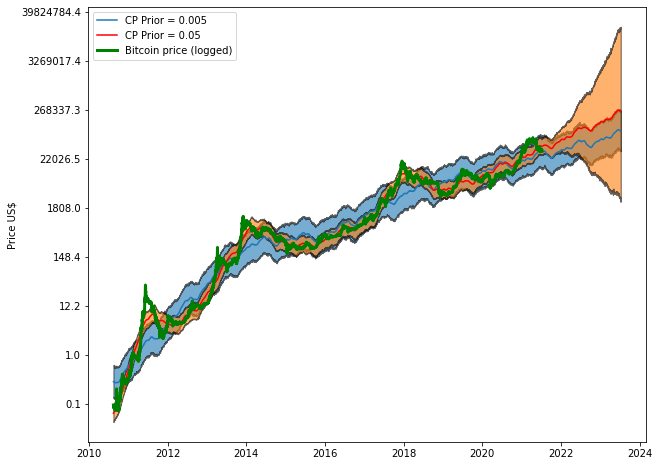

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(output.index, output["yhat_x"], label=labels[0])
ax.fill_between(output.index, output["yhat_upper_x"], output["yhat_lower_x"], alpha=0.6, edgecolor = "k")
ax.plot(output.index, output["yhat_y"], "r", label=labels[1]);
ax.fill_between(output.index, output["yhat_upper_y"], output["yhat_lower_y"], alpha=0.6, edgecolor = "k")
ax.plot(bitcoin.ds, bitcoin.y, color="green", linewidth=3, label=r"Bitcoin price (logged)")
a=ax.get_yticks().tolist()
ax.set_yticklabels(np.round(np.exp(a), 1))
plt.legend(loc="upper left")
plt.ylabel(r"Price US$")
plt.show()

In [12]:
from sklearn.metrics import mean_absolute_error

MAE: 1.858


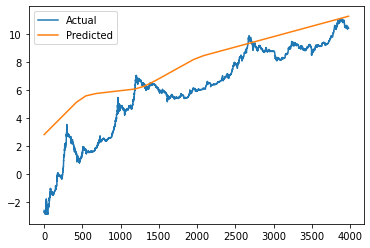

In [13]:
# calculate MAE between expected and predicted values for June
y_true = bitcoin['y'].values
y_pred = output['trend_x'][-3980:].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

# **Ethereum**

In [14]:
KEY = ""
qd.ApiConfig.api_key = KEY
eth = qd.get("BITFINEX/ETHUSD")
eth = eth.loc[(eth !=0).any(1)]

In [15]:
eth = eth.reset_index()
eth.head()

,Date,High,Low,Mid,Last,Bid,Ask,Volume
0,2016-03-14,14.950,11.400,12.9325,12.925,12.925,12.940,22922.937642
1,2016-03-15,13.421,11.607,12.9665,12.765,12.924,13.009,18157.378517
2,2016-03-16,13.890,12.621,12.8200,12.800,12.800,12.840,5431.139409
3,2016-03-17,12.893,10.436,11.2450,11.368,11.172,11.318,25158.103084
4,2016-03-18,11.200,8.338,10.8155,10.750,10.751,10.880,46391.436185


In [16]:
eth["log_y"] = np.log(eth["Last"])
eth = eth.rename(columns={"Date": "ds", "log_y" : "y"})
eth.head()

,ds,High,Low,Mid,Last,Bid,Ask,Volume,y
0,2016-03-14,14.950,11.400,12.9325,12.925,12.925,12.940,22922.937642,2.559163
1,2016-03-15,13.421,11.607,12.9665,12.765,12.924,13.009,18157.378517,2.546707
2,2016-03-16,13.890,12.621,12.8200,12.800,12.800,12.840,5431.139409,2.549445
3,2016-03-17,12.893,10.436,11.2450,11.368,11.172,11.318,25158.103084,2.430802
4,2016-03-18,11.200,8.338,10.8155,10.750,10.751,10.880,46391.436185,2.374906


In [17]:
priors = [0.0005, 0.005]
prophets, labels = [], []
for prior in priors:
    prophet = fbprophet.Prophet(changepoint_prior_scale=prior)
    prophet.fit(eth)
 
    prophets.append(prophet)
    labels.append(r"CP Prior = " + str(prior))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [18]:
forecasts = []
for prophet in prophets:
    forecast = prophet.make_future_dataframe(periods=365 * 2, freq="D")
    forecast = prophet.predict(forecast)
 
    forecast = forecast.rename(columns={"ds" : str(priors[prophets.index(prophet)]) + "_ds"})
    forecasts.append(forecast)

In [19]:
output = pd.merge(forecasts[0], forecasts[1], how = "inner", left_on = "0.0005_ds", right_on = "0.005_ds")
output = output.rename(columns={"0.0005_ds": "Date"}).drop("0.005_ds", axis=1)
output = output.set_index('Date')

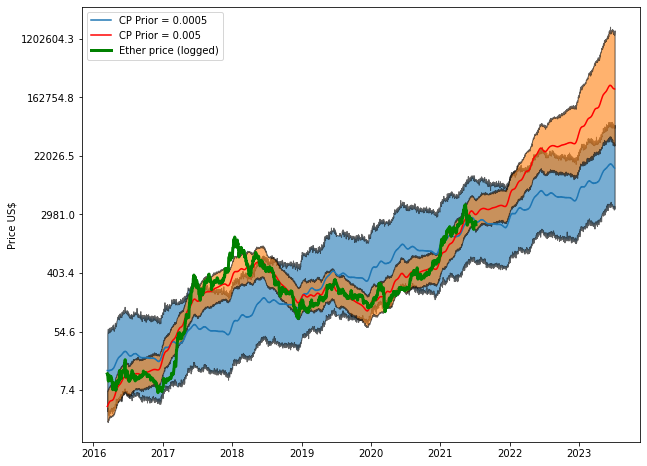

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(output.index, output["yhat_x"], label=labels[0])
ax.fill_between(output.index, output["yhat_upper_x"], output["yhat_lower_x"], alpha=0.6, edgecolor = "k")
ax.plot(output.index, output["yhat_y"], "r", label=labels[1]);
ax.fill_between(output.index, output["yhat_upper_y"], output["yhat_lower_y"], alpha=0.6, edgecolor = "k")
ax.plot(eth.ds, eth.y, color="green", linewidth=3, label=r"Ether price (logged)")
a=ax.get_yticks().tolist()
ax.set_yticklabels(np.round(np.exp(a), 1))
plt.legend(loc="upper left")
plt.ylabel(r"Price US$")
plt.show()

MAE: 1.897


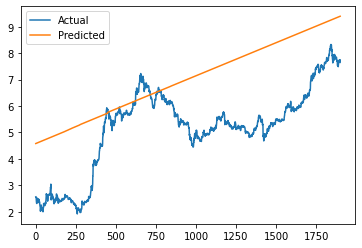

In [25]:
# calculate MAE between expected and predicted values for June
y_true = eth['y'].values
y_pred = output['trend_x'][-1901:].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

# **ETH/BTC**

In [38]:
KEY = ""
qd.ApiConfig.api_key = KEY
ethbtc = qd.get("BITFINEX/ETHBTC")
ethbtc = ethbtc.loc[(ethbtc !=0).any(1)]

In [39]:
ethbtc = ethbtc.reset_index()
ethbtc.head()

,Date,High,Low,Mid,Last,Bid,Ask,Volume
0,2016-03-14,0.050580,0.028241,0.031181,0.031103,0.031102,0.031260,111142.045174
1,2016-03-15,0.032004,0.027950,0.031298,0.031399,0.031207,0.031390,62965.262239
2,2016-03-16,0.033500,0.030465,0.030700,0.030690,0.030690,0.030709,55947.825399
3,2016-03-17,0.030989,0.024759,0.026878,0.026816,0.026821,0.026935,94445.983815
4,2016-03-18,0.026960,0.020150,0.026555,0.026509,0.026506,0.026605,141106.891752


In [40]:
ethbtc["log_y"] = np.log(ethbtc["Last"])
ethbtc = ethbtc.rename(columns={"Date": "ds", "log_y" : "y"})
ethbtc.head()

,ds,High,Low,Mid,Last,Bid,Ask,Volume,y
0,2016-03-14,0.050580,0.028241,0.031181,0.031103,0.031102,0.031260,111142.045174,-3.470451
1,2016-03-15,0.032004,0.027950,0.031298,0.031399,0.031207,0.031390,62965.262239,-3.460979
2,2016-03-16,0.033500,0.030465,0.030700,0.030690,0.030690,0.030709,55947.825399,-3.483818
3,2016-03-17,0.030989,0.024759,0.026878,0.026816,0.026821,0.026935,94445.983815,-3.618757
4,2016-03-18,0.026960,0.020150,0.026555,0.026509,0.026506,0.026605,141106.891752,-3.630271


In [41]:
priors = [0.0015, 0.015]
prophets, labels = [], []
for prior in priors:
    prophet = fbprophet.Prophet(changepoint_prior_scale=prior)
    prophet.fit(ethbtc)
 
    prophets.append(prophet)
    labels.append(r"CP Prior = " + str(prior))

forecasts = []
for prophet in prophets:
    forecast = prophet.make_future_dataframe(periods=365 * 2, freq="D")
    forecast = prophet.predict(forecast)
 
    forecast = forecast.rename(columns={"ds" : str(priors[prophets.index(prophet)]) + "_ds"})
    forecasts.append(forecast)

output = pd.merge(forecasts[0], forecasts[1], how = "inner", left_on = "0.0015_ds", right_on = "0.015_ds")
output = output.rename(columns={"0.0015_ds": "Date"}).drop("0.015_ds", axis=1)
output = output.set_index('Date')

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


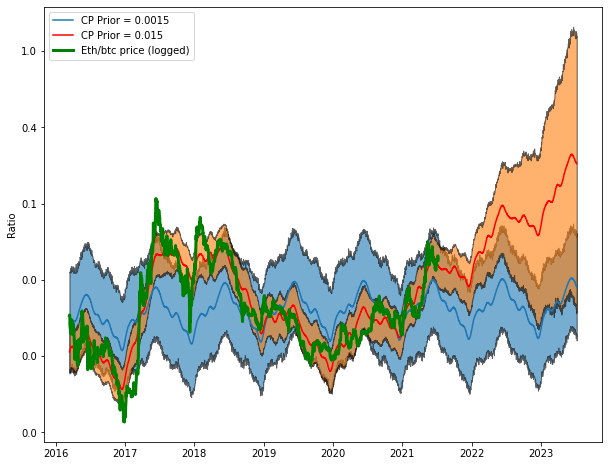

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(output.index, output["yhat_x"], label=labels[0])
ax.fill_between(output.index, output["yhat_upper_x"], output["yhat_lower_x"], alpha=0.6, edgecolor = "k")
ax.plot(output.index, output["yhat_y"], "r", label=labels[1]);
ax.fill_between(output.index, output["yhat_upper_y"], output["yhat_lower_y"], alpha=0.6, edgecolor = "k")
ax.plot(ethbtc.ds, ethbtc.y, color="green", linewidth=3, label=r"Eth/btc price (logged)")
a=ax.get_yticks().tolist()
ax.set_yticklabels(np.round(np.exp(a), 1))
plt.legend(loc="upper left")
plt.ylabel(r"Ratio")
plt.show()

MAE: 0.461


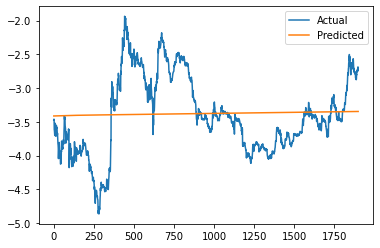

In [44]:
# calculate MAE between expected and predicted values for June
y_true = ethbtc['y'].values
y_pred = output['trend_x'][-1900:].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()